# Supermarket Data: Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [11,4]

## Load Data

In [2]:
days = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday']
df = None
for i,day in enumerate(days):
    new_df = pd.read_csv(f'../data/{day}.csv', sep=';')
    new_df['timestamp'] = pd.to_datetime(new_df['timestamp'], format="%Y-%m-%d %H:%M:%S")
    new_df['customer_no'] = day + '_' + new_df['customer_no'].astype(str)
    if i == 0:
        df = new_df
    else:
        df = pd.concat((df,new_df))

In [3]:
df.head()

,timestamp,customer_no,location
0,2019-09-02 07:03:00,monday_1,dairy
1,2019-09-02 07:03:00,monday_2,dairy
2,2019-09-02 07:04:00,monday_3,dairy
3,2019-09-02 07:04:00,monday_4,dairy
4,2019-09-02 07:04:00,monday_5,spices


In [4]:
df.shape

(24877, 3)

## Cleaning

* When the shop closes, the remaining customers are rushed through the checkout. Their checkout is not recorded, so it may look as if they stay in the market forever.
* Closing time: 10 p.m. (?)

In [5]:
latest_ts = df['timestamp'].max()
closing_time = latest_ts.replace(hour=22, minute=0, second=0) # https://stackoverflow.com/a/26883852
closing_time

Timestamp('2019-09-06 22:00:00')

## Explore

### Total number of customers in each section.

<AxesSubplot:xlabel='location'>

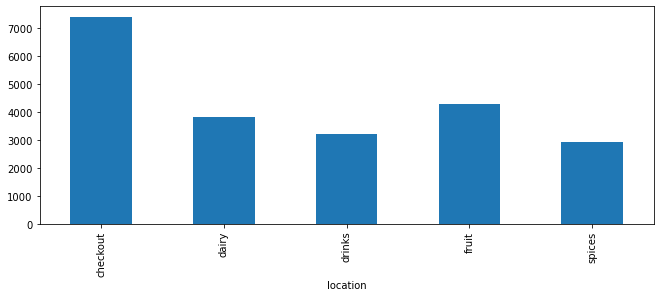

In [6]:
df.groupby('location').nunique()['customer_no'].plot.bar(legend=False)

### Total number of customers in each section over time.

* *Thanks to https://stackoverflow.com/a/48356232*
* see also https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects

In [7]:
df.groupby(['location' , pd.Grouper(key='timestamp',freq='H')]).nunique().unstack(fill_value=0)

customer_no                                          \
timestamp 2019-09-02 07:00:00 2019-09-02 08:00:00 2019-09-02 09:00:00   
location                                                                
checkout                   92                 112                  85   
dairy                      52                  59                  42   
drinks                     52                  55                  48   
fruit                      48                  61                  66   
spices                     41                  42                  36   

                                                                       \
timestamp 2019-09-02 10:00:00 2019-09-02 11:00:00 2019-09-02 12:00:00   
location                                                                
checkout                   90                  55                  73   
dairy                      48                  30                  44   
drinks                     30                  19                  30   
fruit                      43                  35                  48   
spices                     41                  22                  33   

                                                                       \
timestamp 2019-09-02 13:00:00 2019-09-02 14:00:00 2019-09-02 15:00:00   
location                                                                
checkout                  120                  90                  94   
dairy                      57                  51                  54   
drinks                     44                  39                  40   
fruit                      75                  53                  64   
spices                     51                  41                  40   

                               ...                                          \
timestamp 2019-09-02 16:00:00  ... 2019-09-06 12:00:00 2019-09-06 13:00:00   
location                       ...                                           
checkout                   86  ...                  90                 108   
dairy                      42  ...                  37                  63   
drinks                     47  ...                  46                  43   
fruit                      54  ...                  46                  60   
spices                     40  ...                  38                  53   

                                                                       \
timestamp 2019-09-06 14:00:00 2019-09-06 15:00:00 2019-09-06 16:00:00   
location                                                                
checkout                  108                  81                 102   
dairy                      53                  35                  48   
drinks                     39                  37                  47   
fruit                      70                  52                  55   
spices                     44                  31                  45   

                                                                       \
timestamp 2019-09-06 17:00:00 2019-09-06 18:00:00 2019-09-06 19:00:00   
location                                                                
checkout                  115                 148                 135   
dairy                      63                  82                  68   
drinks                     56                  70                  65   
fruit                      75                  89                  76   
spices                     55                  75                  53   

                                                   
timestamp 2019-09-06 20:00:00 2019-09-06 21:00:00  
location                                           
checkout                  103                  52  
dairy                      42                  31  
drinks                     48                  28  
fruit                      57                  28  
spices                     44                  15  

[5 rows x 75 columns]

### Display the number of customers at checkout over time.

<StemContainer object of 3 artists>

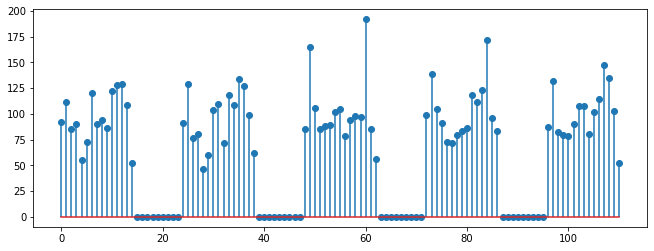

In [8]:
sub_df = df[ df['location'].eq('checkout') ].groupby(pd.Grouper(key='timestamp',freq='H')).nunique()['customer_no']
plt.stem(sub_df)

### The time each customer spent in the market.

*See also https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html#aggregation*

Text(0.5, 1.0, '')

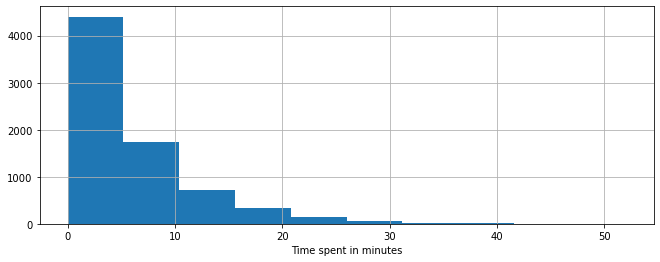

In [9]:
def timedelta_in_minutes(series):
    delta = series.max() - series.min()
    delta_minutes = delta.total_seconds() / 60
    return delta_minutes

df[['timestamp','customer_no']].groupby('customer_no').agg(timedelta_in_minutes).hist()
plt.gca().set_xlabel('Time spent in minutes'); plt.gca().set_title('')

Most customer spend less than 10 minutes.

### Total number of customers in the supermarket over time.

<StemContainer object of 3 artists>

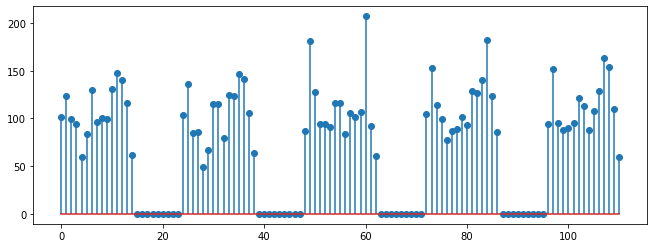

In [10]:
sub_df = df.groupby(pd.Grouper(key='timestamp',freq='H')).nunique()['customer_no']
plt.stem(sub_df)

### Our business managers think that the first section customers visit follows a different pattern than the following ones. Plot the distribution of customers of their first visited section versus following sections (treat all sections visited after the first as “following”).

* *https://stackoverflow.com/a/49263586*
* *https://stackoverflow.com/a/55583395*

In [11]:
# assert sorting
df.sort_values(by='timestamp', inplace=True)

In [12]:
df_first = df.groupby('customer_no').first().groupby('location').count()
df_first

,timestamp
location,
dairy,2141
drinks,1143
fruit,2810
spices,1351


In [13]:
def tail(df):
    return df[1:]
df_following = df.groupby('customer_no').apply(tail).groupby('location').count()[['timestamp']]
df_following

,timestamp
location,
checkout,7417
dairy,2538
drinks,2762
fruit,2312
spices,2403


In [14]:
df_first.rename(mapper={df_first.columns[0]:'first'}, axis=1, inplace=True)
df_following.rename(mapper={df_following.columns[0]:'following'}, axis=1, inplace=True)
df_counts = pd.concat([df_first,df_following],axis=1)

<AxesSubplot:xlabel='location'>

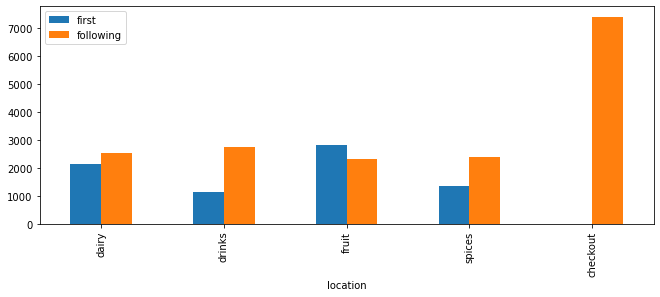

In [15]:
df_counts.plot.bar()

* Nobody starts at checkout which makes sense.
* Significant less people go for drinks or spices at first.

## Markov Chain Model

* https://stackoverflow.com/a/37603767
* https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.DataFrameGroupBy.shift.html
* (!) https://stackoverflow.com/q/57708333

In [16]:
df['location_next'] = df.groupby('customer_no')['location'].shift(-1).fillna('checkout')

### Sanity Check

One specific customer story. Note that we model *checkout* as an absorbing state.

In [17]:
df[ df['customer_no'].eq('monday_6') ]

,timestamp,customer_no,location,location_next
5,2019-09-02 07:04:00,monday_6,spices,dairy
10,2019-09-02 07:05:00,monday_6,dairy,spices
62,2019-09-02 07:17:00,monday_6,spices,drinks
71,2019-09-02 07:18:00,monday_6,drinks,spices
102,2019-09-02 07:25:00,monday_6,spices,dairy
104,2019-09-02 07:26:00,monday_6,dairy,spices
117,2019-09-02 07:27:00,monday_6,spices,checkout
135,2019-09-02 07:29:00,monday_6,checkout,checkout


### Transition Matrix

In [18]:
pd.crosstab(df['location'], df['location_next'], normalize=0)

location_next,checkout,dairy,drinks,fruit,spices
location,,,,,
checkout,1.000000,0.000000,0.000000,0.000000,0.000000
dairy,0.393033,0.000000,0.222483,0.189357,0.195127
drinks,0.537260,0.027145,0.000000,0.218950,0.216645
fruit,0.500195,0.237993,0.136080,0.000000,0.125732
spices,0.251998,0.323122,0.272776,0.152104,0.000000


## Revenue Estimate

Reveneu per minute:
* fruit: 4 €
* spices: 3 €
* dairy: 5 €
* drinks: 6 €

In [19]:
rates = pd.DataFrame(data=dict(fruit=[4], spices=[3], dairy=[5], drinks=[6])).T

In [20]:
df['timestamp_next'] = df.groupby('customer_no')['timestamp'].shift(-1)

In [21]:
df['duration'] = df['timestamp_next'] - df['timestamp']
df['duration'] = df['duration'].dt.total_seconds() / 60

In [22]:
time_spent = df.groupby('location')[['duration']].sum()
time_spent['rates'] = rates
time_spent.fillna(0, inplace=True)
time_spent['revenue'] = time_spent['duration'] * time_spent['rates']
time_spent

,duration,rates,revenue
location,,,
checkout,0.0,0.0,0.0
dairy,17760.0,5.0,88800.0
drinks,9724.0,6.0,58344.0
fruit,12701.0,4.0,50804.0
spices,6273.0,3.0,18819.0


In [24]:
total_revenue = time_spent['revenue'].sum()
print(f"{total_revenue} Euro")

216767.0 Euro
